# Assignment 1 - CNN's and VGG16

*In this assingment, you will further familiraize yourself with CNN's and how to implement them. For this particular example, we will ask you to implement the layer structure of VGG16, an old but fairly effective and simple CNN structure.*

*Keep in mind, that while VGG16 and other CNN's you have implemented so far, only incoporate convolutions and pooling layers, many state-of-the-art models  use a variety of other techniques, such as skip connections (CITATION NEEDED), or self-attention (CITATION NEEDED) to get better results.*

*As you write code for this assignment, try to keep in mind to write good code. That might sound vague, but just imagine that some other poor sod will have to read your code at some point, and easily readable, understandable code, will go a long way to making their life easier. However, this is not a coding course, so the main focus should of course be on the exercises themselves.*

**Keep in mind, this assignment does not count towards your final grade in the course. When any of the exercises mention 'grading', it refers to commenting and correcting answers, not necessarily giving you a score which will reflect in your grade, so dw :)**

## Boilerplate start - you can ignore this!

In [24]:
import os
import torch
import PIL
from torch import nn
from torch.utils.data.dataloader import default_collate

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(sum([115, 107, 105, 98, 105, 100, 105, 32, 116, 111, 105, 108, 101, 116]))


cpu


In [9]:
# Specify dataset you wanna use
def get_dataset(dataset_name, validation_size=0.1, transform=None, v=True):

    if transform is None:
        transform = ToTensor()

    if dataset_name == 'cifar10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

        # Purely for our convenience - Mapping from cifar labels to human readable classes
        cifar10_classes = {
            0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'
        }

    elif dataset_name == 'mnist':
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

    elif dataset_name == 'imagenette':
        download = not os.path.exists('./data/imagenette2')

        # Specific transform in the case we use imagenette
        imagenette_transform = transforms.Compose([
            transforms.Resize(256),        # Resize to 256x256
            transforms.RandomCrop(224),    # Crop the center to 224x224
            transforms.ToTensor(),         # Convert to tensor
            transforms.Normalize(mean=[0.4650, 0.4553, 0.4258], std=[0.2439, 0.2375, 0.2457]) # Normalize each image, numbers because of function courtesy of chatgpt
        ])
        train_set = datasets.Imagenette(root='./data', split='train', download=download, size='full', transform=imagenette_transform)
        test_set = datasets.Imagenette(root='./data', split='val', download=download, size='full', transform=imagenette_transform)
    
    # If we want a validation set of a given size, take it from train set
    if validation_size is not None:
        # These will both be of the torch.utils.data.Subset type (not the Dataset type), and are basically just mappings of indices
        # This does not matter when we make Dataloaders of them, however
        if dataset_name != 'imagenette':
            train_set, validation_set = torch.utils.data.random_split(train_set, [1-validation_size, validation_size])

        # In the case of imagenette, the 'test set' is already a pretty big validation set, so we'll use that to create the test set instead
        else:
            validation_set, test_set = torch.utils.data.random_split(test_set, [validation_size, 1-validation_size])

    if v:
        print(f"There are {len(train_set)} examples in the training set")
        print(f"There are {len(test_set)} examples in the test set \n")

        print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

    return train_set, validation_set, test_set

# collate function just to cast to device, same as in week_3 exercises
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))



## Pre-implementation questions

*These questions are meant to test your general knowledge of CNN's*

### Exercise 1.1

**1. What is the reason we add MaxPooling or AveragePooling in CNN's?**

$\dots$


**2. Say a network comes with a list of class probabilities:** $\hat{p}_1, \hat{p}_2, \dots \hat{p}_N$ **when is the cross-entropy in regards to the *true* class probabilities:** $p_1, p_2, \dots p_N$ **maximized?**

$\dots$

**3. In the [VGG paper](https://arxiv.org/pdf/1409.1556), last paragraph of 'training', page 4, they mention images being randomly cropped after being rescaled. Why do you think they crop images only *after* rescaling them?**

**4. After this, they mention "further augmenting the dataset" by random horizontal flipping and random RGB color shift. Why do you think they do this?**

**5. Why do you think they do not randomly translate images? (Translate being to move images left, right, up, down)**

**6. Which of the following classification tasks do you think is more difficult for a machine learning model, and why?**

- Telling German Shepherds (Schæferhunde) from Labradors
- Telling dogs from cats
- Telling horses from cars from totem poles from chainsaws

**7. In real life, you often find that neural networks aren't used "for everything", older and often more simple models like random forest and linear regression still dominate a lot of fields.**

- Reason a bit about why this is the case

**8. When we sample from our dataloader, we sample in batches, why is this? What would be the alternatives to sampling in batches, and what impact would that have?**

**9. The VGG16-D conv layers all use the same kernel size. Come up with reasons for why you would use bigger/smaller kernel sizes**

**\*10. The "new kid on the block' (relatively speaking) in NLP (Natural Language processing), is self-attention. Basically this is letting each word/token relate to each other word/token by a specific 'attention' value, vaguely showing how much they relate to one another.**

- Would there be any problems in doing this for image processing by simply letting each pixel relate to each other pixel, so we can get spatial information that way instead?



## Boilerplate end - Your implementation work begins here:

*Below, you are given a working example of a CNN, not much different from the one in the exercises of week 3. Your job is to complete the implementation questions below. *

*You do not need to do all the exercises below, or even do them in order, we will obviously only grade the ones you have done, however. Please just mark completed exercises with an X as shown below, so we will know what to look for when grading your assignment. You can add as much text below each question as you want to either argue for your choice of implementation, discuss your results, or ask us questions, we will consider this when grading the assignment.*

**X 0. This marks a question which has been completed**

*For your convenience, we reccommend implementing two models: One bigger for the VGG16-D exercises, meant to be used only with images from the Imagenette dataset, and one smaller, which can also take the other datasets. The model already implemented below should fill the role of the latter.*

*Finally, if you're not able to train the VGG16-D model because it is too big, you can also load the weights of the model using the funciton implemented for exactly that. We do, however, reccommend training it from scratch yourself, if possible.*

______________________________________________________________________________________________



**1. Implement the layer structure of VGG16-D by following either this [Medium article](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918) (fairly easy), or the [official paper](https://arxiv.org/pdf/1409.1556) (slightly harder) (Note: This layer structure is meant to be used with 224x224 sized images, only the  imagenette dataset in this notebook has this)**

**2. Figure out, and implement the type, and exact settings of the optimizer the original VGG16-D implementation used**

**3.** 
- **Can you make the VGG16-D model overfit to the imagenette dataset? If not, what about another dataset?**
- **Can you change the amount of dropout to increase or decrease the rate of overfitting?**
- **Can you make the smaller model overfit to any of its datasets? Is it harder or easier? Explain your answer**

**4. Try to improve the test accuracy of either of your models by changing some of they hyperparameters. To make it easier, try to keep detailed results of your experimental setups and your preliminary results. Argue for your changes. Examples of possible changes are shown below:**:
- **Add more/fewer kernels**
- **Add more/less dropout**
- **Add [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)**
- **Change the intial transform when loading the data to make larger/smaller images**

**5. Change the model (or any other code in the whole script) to make either training, inference, or both, as quick as possible, while still keeping a reasonable test accuracy. You can time training and inference of your network by adding the timeit=True argument. What did you do to achieve this?**



In [10]:
# Compose custom transform
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get data
dataset_name = 'imagenette'
train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1)

# For VGG16, we use channel-wise mean and STD, not pixelwise


# Make dataloaders
batch_size=16
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

There are 9469 examples in the training set
There are 3532 examples in the test set 

Image shape is: torch.Size([3, 224, 224]), label example is 0


In [30]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None, lr=0.001):
        super().__init__()

        conv_stride = 1
        pool_stride = 2
        conv_kernel = (3,3)
        pool_kernel = (2,2)
        dropout_probs = 0.5
        optim_momentum = 0.9
        weight_decay = 5e-4
        learning_rate = 5e-2

        # Define layers as a torch.nn.Sequential object
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding='same'), # dim = in
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, stride=conv_stride, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Flatten(),
            nn.Linear(in_features=features_fore_linear, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=4096, out_features=num_classes)
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        # self.optim = torch.optim.Adam(self.layers.parameters(), lr=learning_rate)
        self.optim = torch.optim.SGD(self.layers.parameters(), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self.forward(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()

            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.test()
                acc = self.eval(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval(self, test_dataloader):
        
        self.test()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        # TODO: REMOVE .CONVERT
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifcations = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classifcation = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifcations.append(classifcation)
            labels.append(label)
            images.append(img)

        return classifcations, labels, images

# def plot_images_and_classifications(images, classifcations):

def get_vgg_weights():
    vgg = VGG16()
    temp = torchvision.models.vgg16(pretrained=True)
    vgg.load_state_dict(temp.state_dict())
    return vgg

3 224
112
56
28
14
7
25088
([tensor([9]), tensor([7]), tensor([7]), tensor([7]), tensor([9]), tensor([9]), tensor([7]), tensor([4]), tensor([9]), tensor([9]), tensor([9]), tensor([9]), tensor([9]), tensor([9]), tensor([9]), tensor([7])], [8, 4, 8, 2, 4, 1, 4, 9, 2, 1, 4, 3, 1, 8, 4, 7])
(tensor([[[-1.9065, -1.9065, -1.9065,  ..., -0.6685, -0.6685, -0.6685],
         [-1.9065, -1.9065, -1.9065,  ..., -0.6685, -0.6685, -0.6685],
         [-1.9065, -1.9065, -1.9065,  ..., -0.6685, -0.6685, -0.6685],
         ...,
         [-0.8453, -0.8132, -0.7810,  ..., -1.9065, -1.9065, -1.9065],
         [-0.8936, -0.8614, -0.8132,  ..., -1.9065, -1.9065, -1.9065],
         [-0.9579, -0.9096, -0.8614,  ..., -1.9065, -1.9065, -1.9065]],

        [[-1.9171, -1.9171, -1.9171,  ...,  0.1965,  0.1965,  0.1965],
         [-1.9171, -1.9171, -1.9171,  ...,  0.1965,  0.1965,  0.1965],
         [-1.9171, -1.9171, -1.9171,  ...,  0.1965,  0.1965,  0.1965],
         ...,
         [-0.1503, -0.0677, -0.0182,  ...,

/tmp/ipykernel_106965/3194574221.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


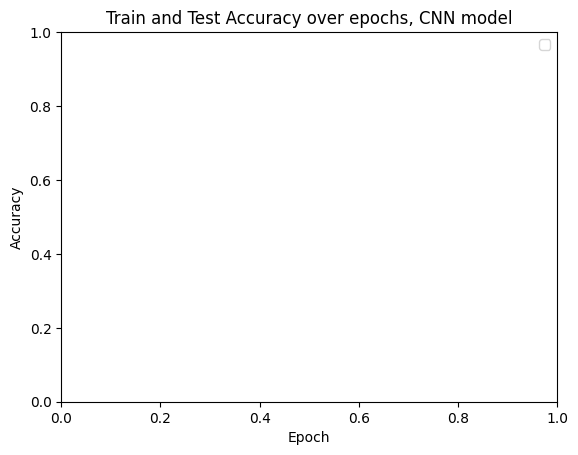

In [31]:
in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]

print(in_channels, in_width_height)

# Make a dummy model to find out the size before the first linear layer
CNN_model = VGG16(num_classes=10, in_channels=in_channels, lr=0.001)
features_fore_linear = get_dim_before_first_linear(CNN_model.layers, in_width_height, in_channels, brain=False)

print(features_fore_linear)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = VGG16(num_classes=10, in_channels=in_channels, features_fore_linear=features_fore_linear, lr=0.001, dataset=test_set) 

train_epochs = 5
# train_accs, test_accs = CNN_model.train(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)
# CNN_model.eval(test_dataloader)

# plot train and test accuracies
# plt.plot(range(train_epochs), train_accs, label='Train')
# plt.plot(range(train_epochs), test_accs, label='Test')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()

# TODO: ADD QUESTION: WHY IS TRAIN ACCURACY MUCH LOWER THAN TEST ACCURACY FOR THE FIRST EPOCH?


# model.forward_checker(torch.zeros(16, 3, 64, 64))


In [18]:
# Util functions

def compute_channel_stats(dataset, batch_size=32):
    """
    Compute the channel-wise mean and standard deviation of all images in a dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): A dataset object that returns (image, label) pairs.
        batch_size (int): Batch size for processing the dataset.
    
    Returns:
        mean (tensor): A tensor containing the channel-wise mean.
        std (tensor): A tensor containing the channel-wise standard deviation.
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    mean_sum = 0.0
    std_sum = 0.0
    total_images = 0

    for images, _ in dataloader:
        images = images.view(images.size(0), images.size(1), -1)
        
        total_images += images.size(0)
        
        mean_sum += images.mean(dim=2).sum(dim=0)
        std_sum += images.var(dim=2, unbiased=False).sum(dim=0)
    
    mean = mean_sum / total_images
    std = torch.sqrt(std_sum / total_images)
    
    return mean, std

def get_dim_before_first_linear(layers, in_dim, in_channels, brain=False):
    """
    Assume square in dimensions, square kernels, cuz I'm lazy
    Also assume kernel numbers and channels match up, because that's trivial enough
    """

    current_dim = in_dim
    current_channels = in_channels
    for layer in layers:
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
            # If the layer padding is same we do not need to change the dimension of the input...
            if layer.padding == 'same':
                if isinstance(layer, nn.Conv2d):
                    current_channels = layer.out_channels
                continue
            vals = {
                'kernel_size': layer.kernel_size if isinstance(layer.kernel_size, int) else layer.kernel_size[0],
                'stride': layer.stride if isinstance(layer.stride, int) else layer.stride[0],
                'padding': layer.padding if isinstance(layer.padding, int) else layer.padding[0],
                'dilation': layer.dilation if isinstance(layer.dilation, int) else layer.dilation[0]
            }
            current_dim = (current_dim + 2*vals['padding'] - vals['dilation']*(vals['kernel_size'])) // vals['stride'] + 1
            print(current_dim)
        if isinstance(layer, nn.Conv2d):
            current_channels = layer.out_channels

        if isinstance(layer, nn.Linear):
            if brain:
                return current_dim, current_channels
            else:
                return current_dim * current_dim * current_channels
        
    raise ValueError("No linear layer found in layers! Why are you even asking me?")